In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [2]:
#Setting up images path
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/7classes_data/"
SELECTED_CLASS = "10000_Pneumonia_Class.csv"
SELECTED_LABEL = "Is_Pneumonia"
SUB = 'Pneumonia'
LABEL = 'Peno_fix2_'
data_dir = Path(PATH)
image_num = len(list(data_dir.glob(SUB+'/*/*/*.jpg')))
image_csv = pd.read_csv(PATH+SELECTED_CLASS)
CLASS_NAME = image_csv[SELECTED_LABEL].unique()
# Check number of TRUE file and all file count        
print(image_num)
print(CLASS_NAME)

10000
['No' 'Yes']


In [3]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator()
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + SUB + "/train/"
VALID_PATH = PATH + SUB +"/valid/"
TEST_PATH = PATH + SUB + "/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
x_train,y_train = next(data_gen_train)
x_valid,y_valid = next(data_gen_valid)
x_test,y_test = next(data_gen_test)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
##Using ResNet50
myResNet = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",trainable=False)
 
myModel = tf.keras.Sequential([
    myResNet,
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1,activation='sigmoid'),
])
myModel.build([None,224,224,3])

In [5]:
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  25615849  
_________________________________________________________________
batch_normalization (BatchNo multiple                  4004      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1002      
Total params: 25,620,855
Trainable params: 3,004
Non-trainable params: 25,617,851
_________________________________________________________________


In [6]:
## Setting up callback function for detecting training status
myEarly = EarlyStopping(monitor='val_loss',patience=5,verbose=1)
myCheckpoint = ModelCheckpoint('Model/'+LABEL+'ResNet50.hdf5'
                               ,monitor='val_loss')
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [7]:
myModel.compile(loss='binary_crossentropy',
                    optimizer=optimizers.SGD(lr=1e-3)
                ,metrics=['accuracy',metrics.Precision(),
               metrics.Recall()])

In [8]:
TRAIN_IMG = 8000
TEST_IMG = 1000
VALID_IMG = 1000

In [9]:
#Training myModel
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
VALID_STEP = np.ceil(VALID_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 150,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 2,
                               callbacks=[myEarly,myCheckpoint,myStop])
myModel.save('Model/'+LABEL+'ResNet50_done.h5')

Train for 250.0 steps, validate for 32.0 steps
Epoch 1/150
250/250 - 32s - loss: 0.7806 - accuracy: 0.5381 - precision: 0.1648 - recall: 0.4808 - val_loss: 0.7479 - val_accuracy: 0.5140 - val_precision: 0.1432 - val_recall: 0.4204
Epoch 2/150
250/250 - 24s - loss: 0.6822 - accuracy: 0.6158 - precision: 0.1887 - recall: 0.4424 - val_loss: 0.6099 - val_accuracy: 0.7080 - val_precision: 0.1006 - val_recall: 0.1083
Epoch 3/150
250/250 - 24s - loss: 0.6233 - accuracy: 0.6702 - precision: 0.2052 - recall: 0.3864 - val_loss: 0.5649 - val_accuracy: 0.7690 - val_precision: 0.1574 - val_recall: 0.1083
Epoch 4/150
250/250 - 25s - loss: 0.5767 - accuracy: 0.7113 - precision: 0.2282 - recall: 0.3560 - val_loss: 0.5390 - val_accuracy: 0.7960 - val_precision: 0.1867 - val_recall: 0.0892
Epoch 5/150
250/250 - 25s - loss: 0.5487 - accuracy: 0.7345 - precision: 0.2450 - recall: 0.3360 - val_loss: 0.5254 - val_accuracy: 0.8170 - val_precision: 0.2500 - val_recall: 0.0828
Epoch 6/150
250/250 - 25s - loss:

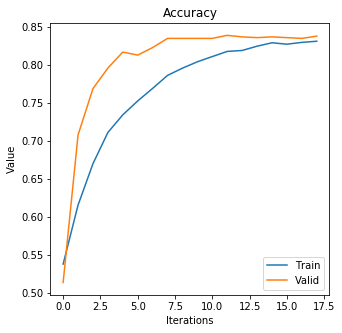

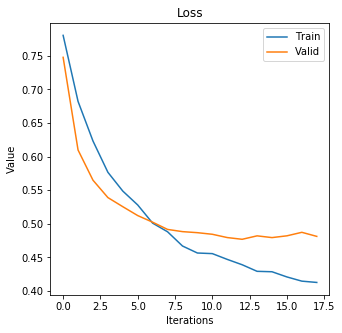

In [10]:
plt.figure(figsize=(5,5))
plt.plot(mySession.history['accuracy'])
plt.plot(mySession.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result/'+LABEL+"ResNet50_Acc.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mySession.history['loss'])
plt.plot(mySession.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result/'+LABEL+"ResNet50_Loss.png")
plt.show()